In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from collections import OrderedDict
from datetime import datetime

## Train, validation and test data

Recall from the previous notebook that we split our images into training, validation and testing data. 20 images for parameter tuning in validation and 20 images for testing the model's accuracy.

<Axes: >

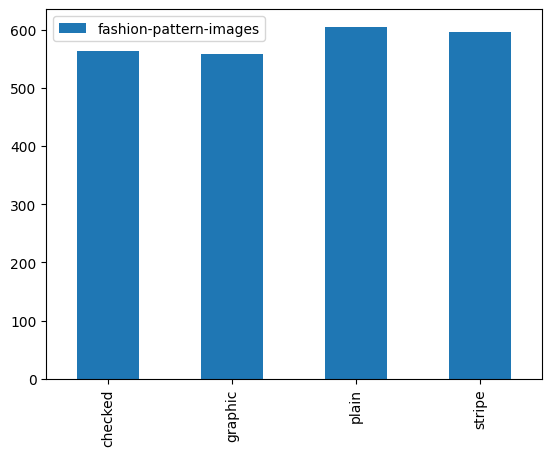

In [10]:
OUTPUT_DIR = "pattern_dataset/"
img_data = {}

for folder in os.listdir(OUTPUT_DIR):
    subfolder_path = OUTPUT_DIR + folder + '/'
    img_data[folder] = {}
    for subfolder in os.listdir(subfolder_path):
        img_data[folder][subfolder] = len(os.listdir(subfolder_path + subfolder))

df = pd.DataFrame.from_dict(img_data, orient='index')
df.T.plot(kind='bar')

I resized and cropped all images so they will be the same size, then loaded the training, validation and testing data.

In [12]:
im_size = 224
transformation = transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(im_size),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ])

 # Load data
train_data = datasets.ImageFolder(
    OUTPUT_DIR + "fashion-pattern-images", transform=transformation
)


# Creating data samplers and loaders:
BATCH_SIZE = 20
train_loader = DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True
)


# Label mapping
class_mapping = train_data.class_to_idx

## Testing image classification models
There are several image classification models out there which were trained on various datasets and built with different architectures. Each model has embeddings for identifying features of images which help classify images into specific classes. I will fine-tune these models at their last layer to output the probability of each image belonging to a specific class. There are multiple versions that denote the number of layers for that model. More layers mean better accuracy but also longer training time. I have also set it to 5 epochs for time constraints.

I will compare the performance of **ResNet** and **VGG**.

In [4]:
def validation(model, criterion, val_loader):
    val_loss = 0
    accuracy = 0

    for images, labels in iter(val_loader):
        output = model.forward(images)
        val_loss += criterion(output, labels).item()

        probabilities = torch.exp(output)

        equality = labels.data == probabilities.max(dim=1)[1]
        accuracy += equality.type(torch.FloatTensor).mean()

    return val_loss, accuracy

In [22]:
def train_model(model, optimizer, criterion, train_loader, epochs=50):
    plot_training = []

    for e in range(epochs):
        model.train()
        running_loss = 0

        for images, labels in iter(train_loader):
            optimizer.zero_grad()

            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Evaluate performance of each epoch
        model.eval()

        # Turn off gradients for validation, saves memory and computations


        print(
            "Epoch: {}/{}.. ".format(e + 1, epochs),
            "Training Loss: {:.3f}.. ".format(running_loss),

            )
        plot_training.append(running_loss)
    
    plt.plot(range(len(plot_training)), plot_training, label='training')
    plt.legend()
    plt.show()

    return model

In [25]:
def save_checkpoint(model, class_mapping, arch):
    """
    Save trained model weights.

    Input:
    arch(str): Model architecture
    """

    checkpoint = {
        "arch": arch,
        "class_to_idx": class_mapping,
        "model_state_dict": model.state_dict(),
    }

    timestamp = datetime.now().date().strftime("%Y%m%d")
    torch.save(checkpoint, f"{timestamp}_{arch}.pth")

#### ResNet

A convolutional neural network (CNN) is designed to scale the number of layers in deep neural networks. As neural networks gain more layers, we expect their performance to increase but it also increases the complexity of the model since we need to tune more parameters. However, the gain in accuracy drops as the model gains complexity. Instead, ResNet uses skip functions to learn the differences between layers, reducing the number of parameters. The result is a better-performing model with lower complexity.

I will use the ResNet version with 50 layers. This [video](https://www.youtube.com/watch?v=GWt6Fu05voI) does an excellent job of explaining the paper introducing ResNet, if you are keen to learn more.

In [15]:
model = models.resnet50(weights=True)
print(model)

C:\Users\roger\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\roger/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 57.4MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

I will freeze the model weights for the top layers since we want to utilise the existing architecture.

In [16]:
# Freeze pretrained model parameters to avoid backpropogating through them
for parameter in model.parameters():
    parameter.requires_grad = False

Then, I will replace the final layer of the model with two layers to finetune it. (1) A fully connected layer to convert the outputs to the correct dimensions for (2) a log softmax layer for the probability of each image being categorised as a rock type. I use softmax because I want to get the probability of a rock being in each class rather than an integer telling me whether the rock is in a certain class or not.

In [17]:
print("Original final layer")
print(model.fc)

# Build custom classifier
num_classes = len(class_mapping)
num_ftrs = model.fc.in_features
classifier = nn.Sequential(
    OrderedDict(
        [
            ("fc", nn.Linear(num_ftrs, num_classes)),
            ("output", nn.LogSoftmax(dim=1)),
        ]
    )
)
model.fc = classifier

print("\nModified final layer")
print(model.fc)

Original final layer
Linear(in_features=2048, out_features=1000, bias=True)

Modified final layer
Sequential(
  (fc): Linear(in_features=2048, out_features=4, bias=True)
  (output): LogSoftmax(dim=1)
)


I will set the loss function and optimiser which define how the model will learn.

The loss function defines the score for each training round. In linear regression, you will typically see the loss function as the residual or mean squared error which shows how wrong each prediction is. MSE penalises wrong answers linearly meaning, whereas the [negative log loss function](https://notesbylex.com/negative-log-likelihood.html#:~:text=Negative%20log-likelihood%20is%20a,all%20items%20in%20the%20batch.) I will use does so exponentially.

For example, if an image's true label is `Granite` but is given a probability `y` of being granite. Then, its loss score will be $-log(y)$. The closer the probability is to the true score `1`, the lower the loss is which means a smaller penalty. But there is a significantly higher penalty given as the probability moves away from the true score towards `0`.

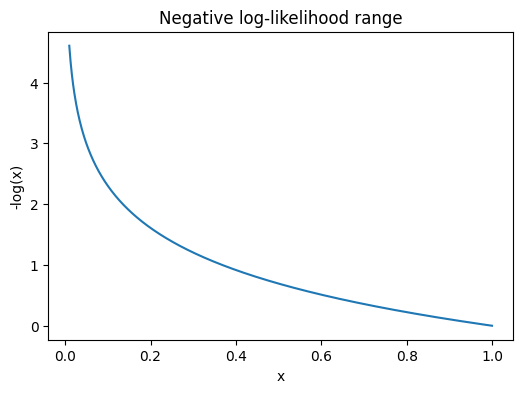

In [18]:
x = np.arange(0.01, 1.0, 0.001)
y = -np.log(x)

fig,ax = plt.subplots(figsize=(6,4))
ax.plot(x,y)
plt.ylabel('-log(x)')
plt.xlabel('x')
plt.title('Negative log-likelihood range')
plt.show()

The optimiser determines how the model uses the calculated loss to learn. Once you know how good/bad your results are, what do you do next to find the lowest possible loss? 

In a linear regression problem like $mx+c=y$, this might mean figuring out how much to change `m` and `c` to get the lowest possible MSE, preferably in the fewest steps. Typically, we set a learning rate that says how much we should change the weights each time. We might set an optimiser with a variable learning rate that makes bigger changes to weights if the loss is high and smaller changes if the loss is low. 

I chose the Adam optimiser which is known for relatively fast convergence and is a popular choice in the field.

You can watch a more in-depth video explaining optimizers [here](https://www.youtube.com/watch?v=mdKjMPmcWjY).

In [19]:
# Loss function and gradient descent
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

Now that I've set up the model, I can train it. Typically, you would train the model until the loss plateaus which means that the model has converged on a minimum (not necessarily global) and will not improve. However, due to time constraints, I will do a maximum of 50 epochs.

Epoch: 1/50..  Training Loss: 86.945.. 
Epoch: 2/50..  Training Loss: 55.230.. 
Epoch: 3/50..  Training Loss: 48.681.. 
Epoch: 4/50..  Training Loss: 46.616.. 
Epoch: 5/50..  Training Loss: 44.972.. 
Epoch: 6/50..  Training Loss: 39.671.. 
Epoch: 7/50..  Training Loss: 41.328.. 
Epoch: 8/50..  Training Loss: 36.750.. 
Epoch: 9/50..  Training Loss: 40.216.. 
Epoch: 10/50..  Training Loss: 35.736.. 
Epoch: 11/50..  Training Loss: 33.748.. 
Epoch: 12/50..  Training Loss: 33.728.. 
Epoch: 13/50..  Training Loss: 33.633.. 
Epoch: 14/50..  Training Loss: 32.746.. 
Epoch: 15/50..  Training Loss: 37.034.. 
Epoch: 16/50..  Training Loss: 32.364.. 
Epoch: 17/50..  Training Loss: 32.431.. 
Epoch: 18/50..  Training Loss: 30.567.. 
Epoch: 19/50..  Training Loss: 29.924.. 
Epoch: 20/50..  Training Loss: 33.896.. 
Epoch: 21/50..  Training Loss: 29.542.. 
Epoch: 22/50..  Training Loss: 30.527.. 
Epoch: 23/50..  Training Loss: 31.111.. 
Epoch: 24/50..  Training Loss: 28.504.. 
Epoch: 25/50..  Training 

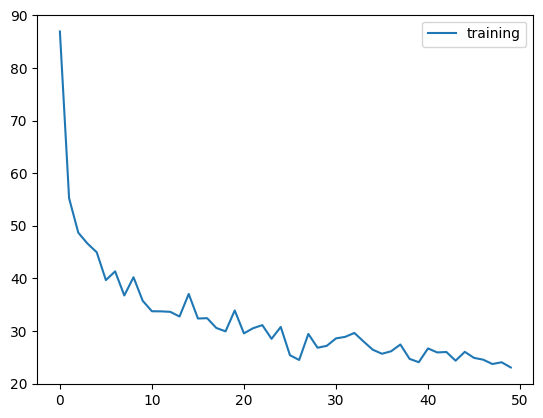

In [23]:
# Train model
resnet_model = train_model(model, optimizer, criterion, train_loader)

It is worth noting that the data cleaning phase made a *big* difference to our results. Before cleaning, the training accuracy remained around 45%-55% with 100 epochs. Now, the training accuracy beats that of another baseline on Kaggle with only 50 epochs!

If I trained this model for longer, it is likely that we will get a better accuracy since the training loss has not plateaued yet!

In [26]:
save_checkpoint(resnet_model, class_mapping, 'resnet50')

{'checked': 0, 'graphic': 1, 'plain': 2, 'stripe': 3}

The VGG16 results are less accurate than ResNet50 and its loss appears to be plateauing which is another signal that it does not perform as well as the ResNet50 model.

## Testing
The moment of truth! I will test the ResNet50 model.

There is a markedly better performance for the classes with more unique images (ie: higher initial sample size). This makes sense since it is trained on a wider variety of images which gives it more opportunities to pick out salient features for each class. Before I cleaned the images, I ran the ResNet50 model on a 100 epochs a which yielded a training accuracy barely grazing 60%. This model is about 5% better with 65% overall accuracy.

In [7]:
from sklearn.metrics import classification_report

model.eval()

with torch.no_grad():
    predictions = []
    true_labels = []

    for images, labels in iter(test_loader):
        output = model.forward(images)
        probabilities = torch.exp(output)
        predictions += probabilities.max(dim=1)[1].tolist()
        true_labels += labels.tolist()

print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.78      0.35      0.48        20
           1       0.81      0.85      0.83        20
           2       0.77      0.50      0.61        20
           3       0.56      0.75      0.64        20
           4       0.47      0.37      0.41        19
           5       0.53      0.80      0.64        20
           6       0.79      0.95      0.86        20

    accuracy                           0.65       139
   macro avg       0.67      0.65      0.64       139
weighted avg       0.67      0.65      0.64       139



So how might we improve the accuracy of the results?

- Increase the training size by adding augmented images for all classes
- Experiment with adding more layers to the model
- Add more epochs (increase training time) to find the minimum loss
- Increase the depth of the ResNet model

## Code to load a checkpointed model

In [29]:
def load_checkpoint(filepath, class_mapping):

    if os.path.exists(filepath):
        checkpoint = torch.load(filepath)
        num_classes = len(class_mapping)

        if "resnet50" in checkpoint["arch"]:
            model = models.resnet50(pretrained=True)
            num_ftrs = model.fc.in_features
            classifier = nn.Sequential(
            OrderedDict(
                [
                    ("fc", nn.Linear(num_ftrs, num_classes)),
                    ("output", nn.LogSoftmax(dim=1)),
                ]
            )
        )
            model.fc = classifier
        
        else:
            return print("Architecture not recognized.")

        for param in model.parameters():
            param.requires_grad = False

        model.class_to_idx = checkpoint["class_to_idx"]        
        model.load_state_dict(checkpoint["model_state_dict"])

        return model
    
    else:
        print("No such checkpoint found.")

### VGG16 Results

In [30]:
class_mapping={'checked': 0, 'graphic': 1, 'plain': 2, 'stripe': 3}
model = load_checkpoint('20240514_resnet50.pth', class_mapping)

C:\Users\roger\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\roger\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [45]:
from PIL import Image

model.eval()
img = Image.open('1931.jpg').convert("RGB")
img = transformation(img)
image = img.view([1, img.shape[0], img.shape[1], img.shape[2]])
with torch.no_grad():


    output = model.forward(image)
    probabilities = torch.exp(output)
    print(probabilities)
    predictions = probabilities.max(dim=1)[1].tolist()
print(predictions)

tensor([[0.3348, 0.0012, 0.6483, 0.0157]])
[2]
